In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Load the CSV into a DataFrame
df = pd.read_csv(list(uploaded.keys())[0])

Saving User_Expenditure_Data.csv to User_Expenditure_Data.csv


In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create user categories based on monthly income
def categorize_users(df):
    conditions = [
        (df['MonthlyIncome'] < 4000),
        (df['MonthlyIncome'] >= 4000) & (df['MonthlyIncome'] < 6000),
        (df['MonthlyIncome'] >= 6000)
    ]
    choices = ['Low Income', 'Middle Income', 'High Income']
    df['IncomeCategory'] = np.select(conditions, choices)
    return df

# Apply the function to categorize users based on their income
df = categorize_users(df)

# Function to train Prophet and NN model for each user
def train_user_models(df):
    user_models = {}

    for user_id in df['UserID'].unique():
        user_data = df[df['UserID'] == user_id]

        # Prepare data for Prophet
        forecast_data = user_data[['Date', 'TotalMonthlyExpenses']].rename(columns={'Date': 'ds', 'TotalMonthlyExpenses': 'y'})

        # Initialize and fit Prophet model
        m = Prophet(daily_seasonality=False)
        m.fit(forecast_data)

        # Make future predictions
        future = m.make_future_dataframe(periods=12, freq='M')
        forecast = m.predict(future)

        # Calculate residuals for the neural network
        historical_forecast = m.predict(forecast_data[['ds']])
        user_data['yhat'] = historical_forecast['yhat']
        user_data['residuals'] = user_data['TotalMonthlyExpenses'] - user_data['yhat']

        # Prepare data for NN
        X = np.array(user_data.index).reshape(-1, 1)
        y = user_data['residuals'].values

        # Define and train neural network
        nn_model = Sequential([
            Dense(64, input_dim=1, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='linear')
        ])
        nn_model.compile(optimizer='adam', loss='mse')
        nn_model.fit(X, y, epochs=20, verbose=0)

        # Store model and forecast for the user
        user_models[user_id] = {
            'prophet_model': m,
            'nn_model': nn_model,
            'forecast': forecast
        }

    return user_models

# Train models for all users
user_models = train_user_models(df)

# Function to analyze user number 100
def analyze_user(user_id, df, user_models):
    user_data = df[df['UserID'] == user_id]
    income_category = user_data['IncomeCategory'].iloc[0]

    # Get model for user 100
    model = user_models[user_id]
    forecast = model['forecast']

    # Get NN adjustment for future predictions
    future_index = np.array(range(len(user_data), len(user_data) + 12)).reshape(-1, 1)
    nn_adjustment = model['nn_model'].predict(future_index)

    # Add noise for non-linearity
    noise = np.random.normal(0, 0.05 * nn_adjustment.std(), nn_adjustment.shape)
    nn_adjustment_noisy = nn_adjustment.flatten() + noise.flatten()

    # Apply NN adjustment to future predictions
    future_forecast = forecast.iloc[len(user_data):]
    future_forecast['yhat_adjusted'] = future_forecast['yhat'] + nn_adjustment_noisy

    # Define a lower bound based on 10% of the user's mean expenses to avoid 0 predictions
    min_threshold = max(0.1 * user_data['TotalMonthlyExpenses'].mean(), 500)  # At least $500 or 10% of the mean

    # Clamp negative values and overly low predictions to this threshold
    future_forecast['yhat_adjusted'] = future_forecast['yhat_adjusted'].apply(lambda x: max(min_threshold, x))

    # Display recommendations based on user's income category
    if income_category == 'Low Income':
        print(f"People in your income category (Low Income) tend to spend less. Based on your spending, you're in the {'upper' if user_data['TotalMonthlyExpenses'].mean() > 3000 else 'lower'} range.")
    elif income_category == 'Middle Income':
        print(f"People in your income category (Middle Income) have moderate spending. You're in the {'upper' if user_data['TotalMonthlyExpenses'].mean() > 4500 else 'lower'} range.")
    else:
        print(f"People in your income category (High Income) tend to spend more. You're in the {'upper' if user_data['TotalMonthlyExpenses'].mean() > 6000 else 'lower'} range.")

    # Plot the forecast for user 100
    plt.figure(figsize=(10, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Prediction', color='blue')
    plt.plot(future_forecast['ds'], future_forecast['yhat_adjusted'], label='NN Adjusted Prediction (with Noise)', color='green')
    plt.scatter(user_data['Date'], user_data['TotalMonthlyExpenses'], color='red', label='User 100 Data Points', zorder=5)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.legend()
    plt.title(f'Expense Forecast for User {user_id} (Hybrid Model)')
    plt.xlabel('Date')
    plt.ylabel('Expenditure')
    plt.grid(True)
    plt.show()

# # Run analysis for user number 100
# analyze_user(100, df, user_models)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjghyyc6j/3e3iowtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjghyyc6j/d0b8fd1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18342', 'data', 'file=/tmp/tmpjghyyc6j/3e3iowtc.json', 'init=/tmp/tmpjghyyc6j/d0b8fd1j.json', 'output', 'file=/tmp/tmpjghyyc6j/prophet_modelf4t1e639/prophet_model-20240927172228.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:28 - cmdstanpy - INFO - Chain [1] done processing
INF

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
People in your income category (Low Income) tend to spend less. Based on your spending, you're in the lower range.


<ipython-input-5-e38eac67c8c4>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['yhat_adjusted'] = future_forecast['yhat'] + nn_adjustment_noisy
<ipython-input-5-e38eac67c8c4>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['yhat_adjusted'] = future_forecast['yhat_adjusted'].apply(lambda x: max(min_threshold, x))


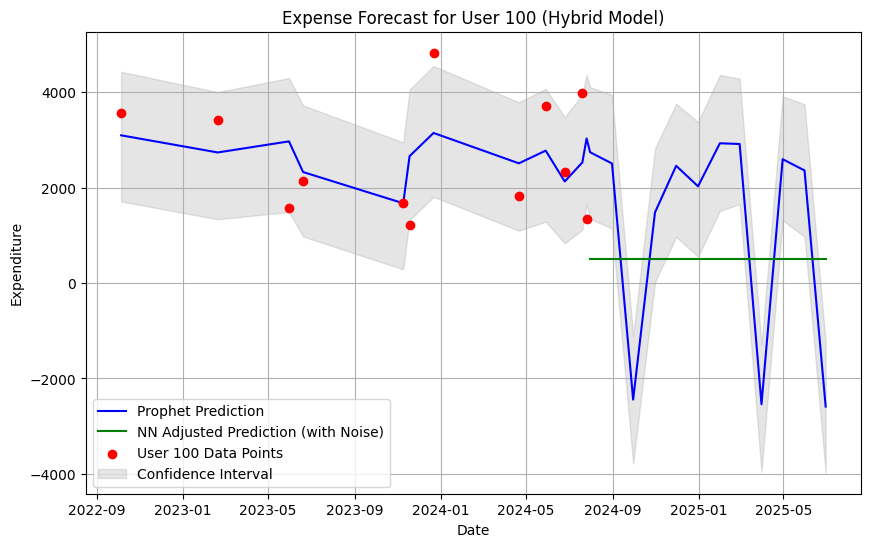

In [6]:
# Run analysis for user 100
analyze_user(100, df, user_models)

In [8]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.8 MB/s eta 0:00:00


In [40]:
import gradio as gr
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import requests

# API Key for AI21 Studio (Jamba 1.5 models)
ai21_api_key = 'nqnVVLHphEwgyX5m15At02WQNDrVkcm8'

# Function to generate dynamic suggestions using AI21 Jamba 1.5 model
def generate_suggestion(income_category, spending_level):
    try:
        # Modify the base prompt to ensure the model generates points without explanation
        if income_category == 'Low Income':
            base_prompt = (
                f"As someone in the low-income category, you tend to be in the {spending_level} range of spending. "
                "Provide a brief list of 3-5 actionable points on how to improve your credit score or manage debt. "
                "Do not explain each point, just list them as bullet points."
            )
        elif income_category == 'Middle Income':
            base_prompt = (
                f"People in the middle-income category tend to fall in the {spending_level} range of spending. "
                "Provide a brief list of 3-5 actionable points on how to manage loans or improve spending habits. "
                "Do not explain each point, just list them as bullet points."
            )
        else:
            base_prompt = (
                f"In the high-income category, many people are in the {spending_level} range of spending. "
                "Provide a brief list of 3-5 points on how to manage investments or handle high-value purchases. "
                "Do not explain each point, just list them as bullet points."
            )

        # Prepare the request body as per Jamba 1.5 model requirements
        headers = {
            'Authorization': f'Bearer {ai21_api_key}',
            'Content-Type': 'application/json'
        }
        data = {
            "model": "jamba-1.5-large",  # You can switch between jamba-1.5-mini and jamba-1.5-large
            "messages": [
                {
                    "role": "user",
                    "content": base_prompt
                }
            ],
            "max_tokens": 60,  # Limit to concise output
            "temperature": 0.7  # Control randomness of output
        }

        # Send the request to AI21 Studio API (Jamba 1.5)
        response = requests.post('https://api.ai21.com/studio/v1/chat/completions', headers=headers, json=data)

        # Inspect the response
        result = response.json()

        # Check if the response contains the expected structure
        if 'choices' in result and len(result['choices']) > 0:
            output_text = result['choices'][0]['message']['content'].strip()
            return output_text
        else:
            # If the structure is not as expected, log the entire response for debugging
            print("Unexpected API response:", result)
            return "Error: Unexpected response structure. Please check the API response."

    except Exception as e:
        return f"Error generating suggestion: {e}"

# Function to generate user explanation (for income bracket and spending level)
def generate_explanation(income_category, spending_level):
    if income_category == 'Low Income':
        return f"People in your income category (Low Income) tend to spend less. You're in the {spending_level} range."
    elif income_category == 'Middle Income':
        return f"People in your income category (Middle Income) have moderate spending. You're in the {spending_level} range."
    else:
        return f"People in your income category (High Income) tend to spend more. You're in the {spending_level} range."

# Main function to analyze a user and generate results
def analyze_user_gradio(user_id):
    try:
        user_id = int(user_id)  # Convert input to integer
        user_data = df[df['UserID'] == user_id]
        income_category = user_data['IncomeCategory'].iloc[0]

        # Determine spending level based on the user's average spending
        avg_spending = user_data['TotalMonthlyExpenses'].mean()
        if income_category == 'Low Income':
            spending_level = 'upper' if avg_spending > 3000 else 'lower'
        elif income_category == 'Middle Income':
            spending_level = 'upper' if avg_spending > 4500 else 'lower'
        else:
            spending_level = 'upper' if avg_spending > 6000 else 'lower'

        # Generate explanation and suggestion
        explanation = generate_explanation(income_category, spending_level)
        suggestion = generate_suggestion(income_category, spending_level)

        # Get model for the specified user
        model = user_models[user_id]
        forecast = model['forecast']

        # Get NN adjustment for future predictions
        future_index = np.array(range(len(user_data), len(user_data) + 12)).reshape(-1, 1)
        nn_adjustment = model['nn_model'].predict(future_index)

        # Apply NN adjustment
        future_forecast = forecast.iloc[len(user_data):]
        future_forecast['yhat_adjusted'] = future_forecast['yhat'] + nn_adjustment.flatten()

        # Clamp predictions to prevent negatives
        min_threshold = max(0.1 * user_data['TotalMonthlyExpenses'].mean(), 500)
        future_forecast['yhat_adjusted'] = future_forecast['yhat_adjusted'].apply(lambda x: max(min_threshold, x))

        # Plot the forecast
        plt.figure(figsize=(10, 6))
        plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Prediction', color='blue')
        plt.plot(future_forecast['ds'], future_forecast['yhat_adjusted'], label='NN Adjusted Prediction', color='green')
        plt.scatter(user_data['Date'], user_data['TotalMonthlyExpenses'], color='red', label='User Data Points')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Expenditure')
        plt.grid(True)
        plt.savefig('forecast_plot.png')
        plt.close()

        # Return the results
        return 'forecast_plot.png', explanation, suggestion

    except Exception as e:
        return None, f"Error: {e}", "No suggestion available."

# Gradio interface
interface = gr.Interface(
    fn=analyze_user_gradio,  # Function that generates the plot, explanation, and suggestion
    inputs=gr.components.Number(label="Enter User ID"),  # Input field for user ID
    outputs=[
        gr.components.Image(type="filepath", label="Expenditure Forecast Plot"),  # Display plot
        gr.components.Textbox(label="Explanation"),  # Explanation
        gr.components.Textbox(label="Suggestion")  # Suggestion
    ],
    title="Expenditure Forecast & Recommendation"
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://224b9696f40d6bc586.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
